# Stats Modelling

Taking the stats df generated from combined_analysis.ipynb

In [1]:
import os
import pprint
import tqdm
import json
import glob
import jsonlines
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
from collections import Counter
import datetime
import h5py
from typing import NamedTuple
import re
import statsmodels.api as sm
from collections import defaultdict
from operator import attrgetter
import statsmodels.formula.api as smf
from pandas.plotting import scatter_matrix

#load in search hashtags
with open('../references/search_hashtags.txt', 'r') as f:
    search_hashtags = f.readlines()
    search_hashtags = [i.replace('\n', '') for i in search_hashtags]
    search_hashtags = [i.replace('#', '') for i in search_hashtags]
    search_hashtags = [i.lower() for i in search_hashtags]
    search_hashtags.remove('وأناكمان')

# Define Functions for analysis

In [2]:
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

def normalise(df):
    stats_df_normalised = df.copy()
    for col in ['int_pre_peak',
        'act_pre_peak',
        'act_pre_peak_avg',
        'act_post_peak',
        'act_post_peak_avg',
        'norm_act_pre_peak',
        'norm_act_pre_peak_avg',
        'act_pre_peak_avg',
        'likes_std',
        'interval_minutes']:

        stats_df_normalised[col] = min_max_scaling(df[col])

    stats_df_normalised = stats_df_normalised[~stats_df_normalised['interval_minutes'].isnull()]
    stats_df_normalised['interval_minutes'] = 1-stats_df_normalised['interval_minutes']

    return stats_df_normalised

In [3]:
def scatter_vis(df, target = 'act_post_peak', group_num = 1):

    x = scatter_matrix(df[['int_pre_peak',
    'act_pre_peak',
    'norm_act_pre_peak',
    'likes_std',
    'reciprocal',
    'weight',
    'percent_reciprocal',
    target]],figsize=(20,15));

    plt.savefig(f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/results/0{group_num}_group/scatter_{target}.png')

def read_in_data(group_num):
    save_filename = f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/06_reporting/stats_df_group_{group_num}.obj'
    with open(save_filename, 'rb') as f:
        stats_df = pickle.load(f)
    return stats_df

In [4]:
def model_selection(data, response, family=sm.families.family.NegativeBinomial(alpha=2), forward=True, subset_ht = None):
    '''Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    '''

    remaining = set(data.columns)
    remaining.remove(response)
    if subset_ht:
        data = data[data['ht']==subset_ht]
        data = data.drop(['ht'],axis=1)
        remaining.remove('ht')
    if forward:
        selected = []
    else:
        # for backward selection, start with the full set.
        selected = remaining.copy()
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            if forward:
                formula = "{} ~ {} + 1".format(response,
                                            ' + '.join(selected + [candidate]))
            else:
                formula = "{} ~ {} + 1".format(response,
                                            ' + '.join([i for i in selected if i!=candidate]))
            try:
                score = smf.glm(formula, data, family=family).fit().aic
            except ValueError:
                continue
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            if forward:
                remaining.remove(best_candidate)
                selected.append(best_candidate)
                current_score = best_new_score
            else:
                remaining.remove(best_candidate)
                selected.remove(best_candidate)
                current_score = best_new_score
        else:
            break
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.glm(formula, data, family=family).fit()
    return model

def write_to_latex(summary, group_num, dep_var, forward=True):
    results_folder = f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/results/0{group_num}_group'
    write_string = summary.as_latex()
    if forward:
        forward_str='forward'
    else:
        forward_str='backward'
    res_file = os.path.join(results_folder, f'table_{dep_var}_{forward_str}.tex')

    with open(res_file, 'w') as f:
        f.writelines(write_string)

# Group 1: 2017-11-16 to 2018-05-29

In [5]:
group_num = 1
hashtag_split = True
ngram_range = '34'
min_user = 100

overwrite = True
read_in = True

df = read_in_data(group_num)
# df = normalise(df)

## Research Question 1

In [6]:
# df['primary_ht'].describe()

In [7]:
df

,author_id,int_pre_peak,act_pre_peak,act_pre_peak_avg,norm_act_pre_peak,norm_act_pre_peak_avg,act_post_peak,act_post_peak_avg,ht,likes_std,...,gender,lang,hashtag_lang,lang_diff,interval,interval_minutes,same_cluster_change,weight,reciprocal,percent_reciprocal
0,1126372568,6,11.0,0.196429,39,0.696429,0.0,0.000000,balancetonporc,0,...,True,en,fr,True,0 days 07:40:26,460.433333,0.0,2.0,0.0,0.0
1,118866507,1,11.0,0.196429,222,3.964286,0.0,0.000000,balancetonporc,0,...,True,fr,fr,False,NaT,NaN,NaN,NaN,NaN,NaN
2,1235678017,2,4.0,0.071429,549,9.803571,0.0,0.000000,balancetonporc,0,...,True,fr,fr,False,NaT,NaN,NaN,NaN,NaN,NaN
3,148746108,10,10.0,0.178571,614,10.964286,2.0,0.014184,balancetonporc,1,...,False,un,fr,True,NaT,NaN,1.0,2.0,0.0,0.0
4,1514035297,1,0.0,0.000000,163,2.910714,0.0,0.000000,balancetonporc,0,...,True,un,fr,True,78 days 08:32:50,112832.833333,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2721,3201751805,27,54.0,0.593407,18,0.197802,0.0,0.000000,我也是,4,...,False,en,zh,True,NaT,NaN,0.0,5.0,0.0,0.0
2722,779091151127138304,2,6.0,0.400000,150,10.000000,41.0,0.225275,私も,0,...,True,un,ja,True,0 days 23:51:21,1431.350000,0.0,1.0,0.0,0.0
2723,882037037355876352,26,3.0,0.200000,37,2.466667,64.0,0.351648,私も,2,...,False,un,ja,True,9 days 02:28:49,13108.816667,0.0,2.0,0.0,0.0
2724,3201751805,19,33.0,0.257812,18,0.140625,0.0,0.000000,나도,3,...,False,en,ko,True,NaT,NaN,0.0,5.0,0.0,0.0


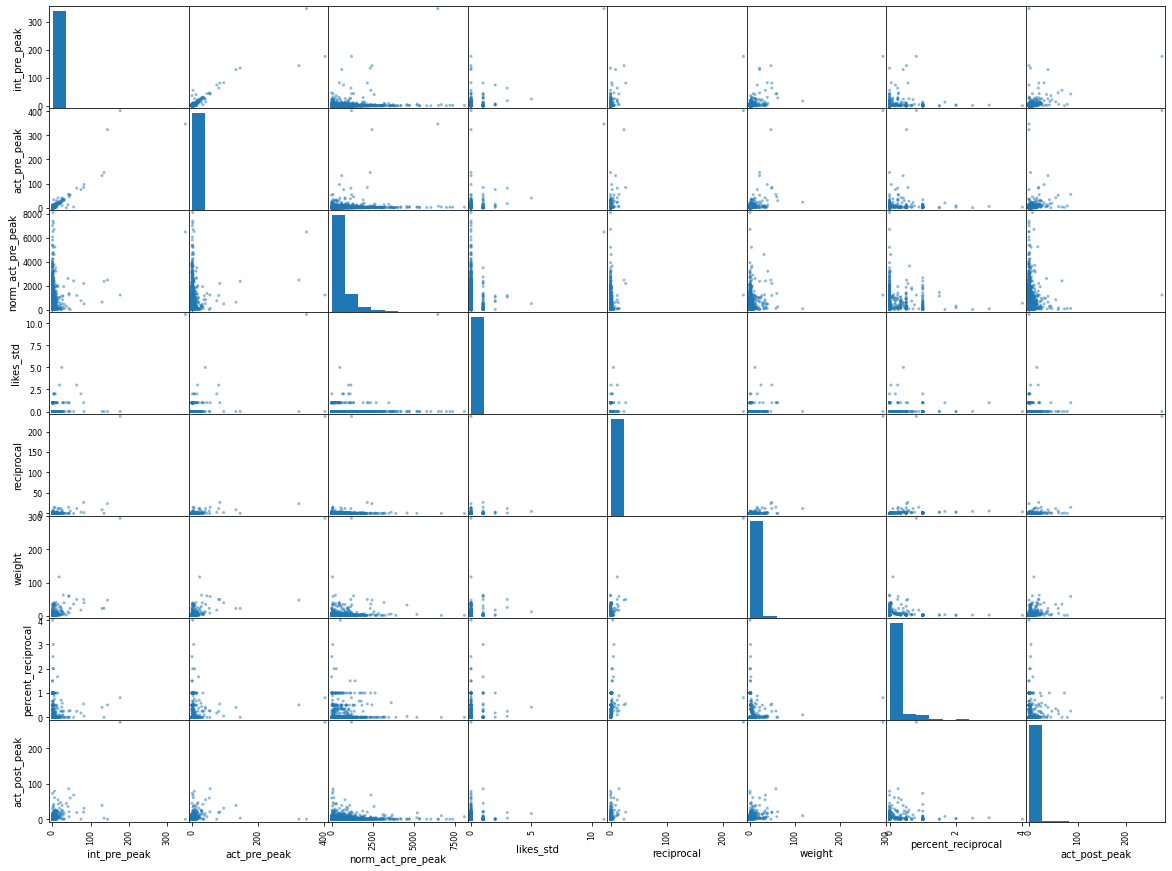

In [37]:
scatter_vis(df, target = 'act_post_peak', group_num=group_num)

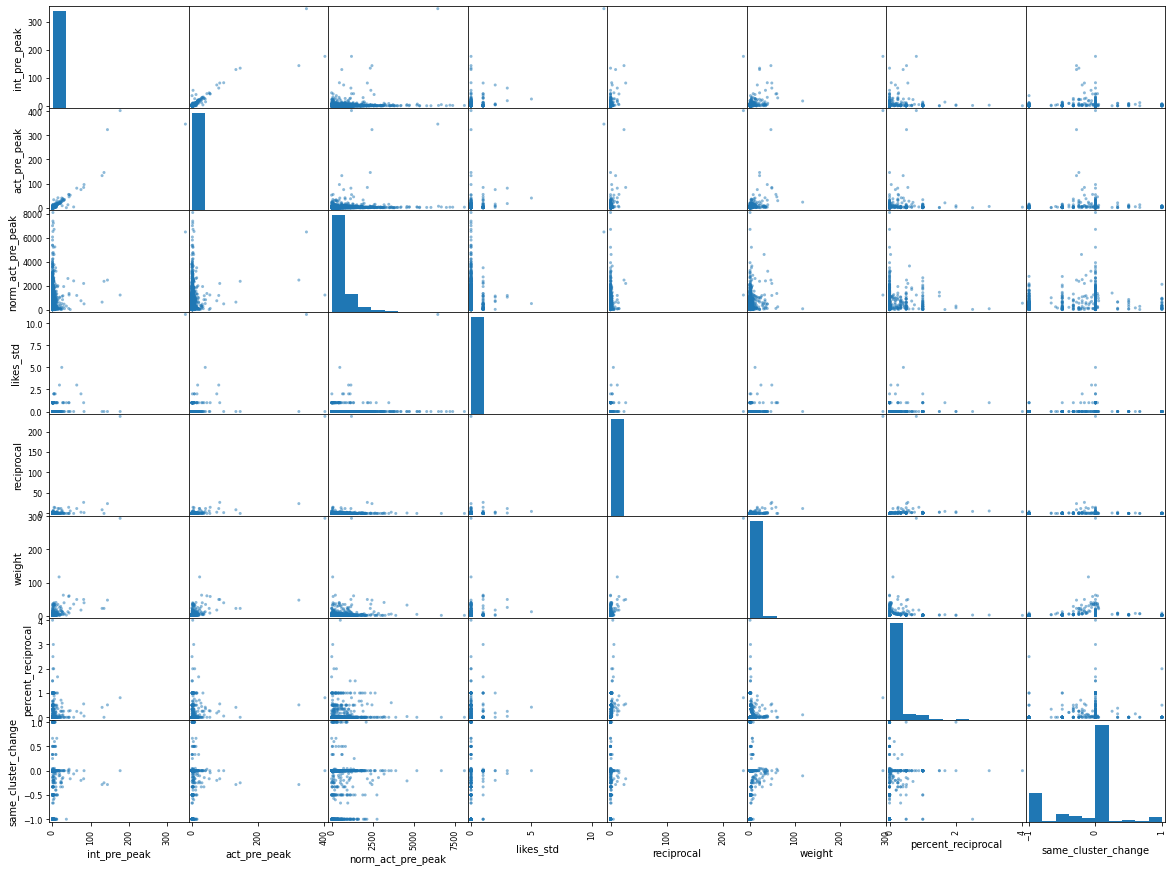

In [38]:
scatter_vis(df, target = 'same_cluster_change', group_num=group_num)

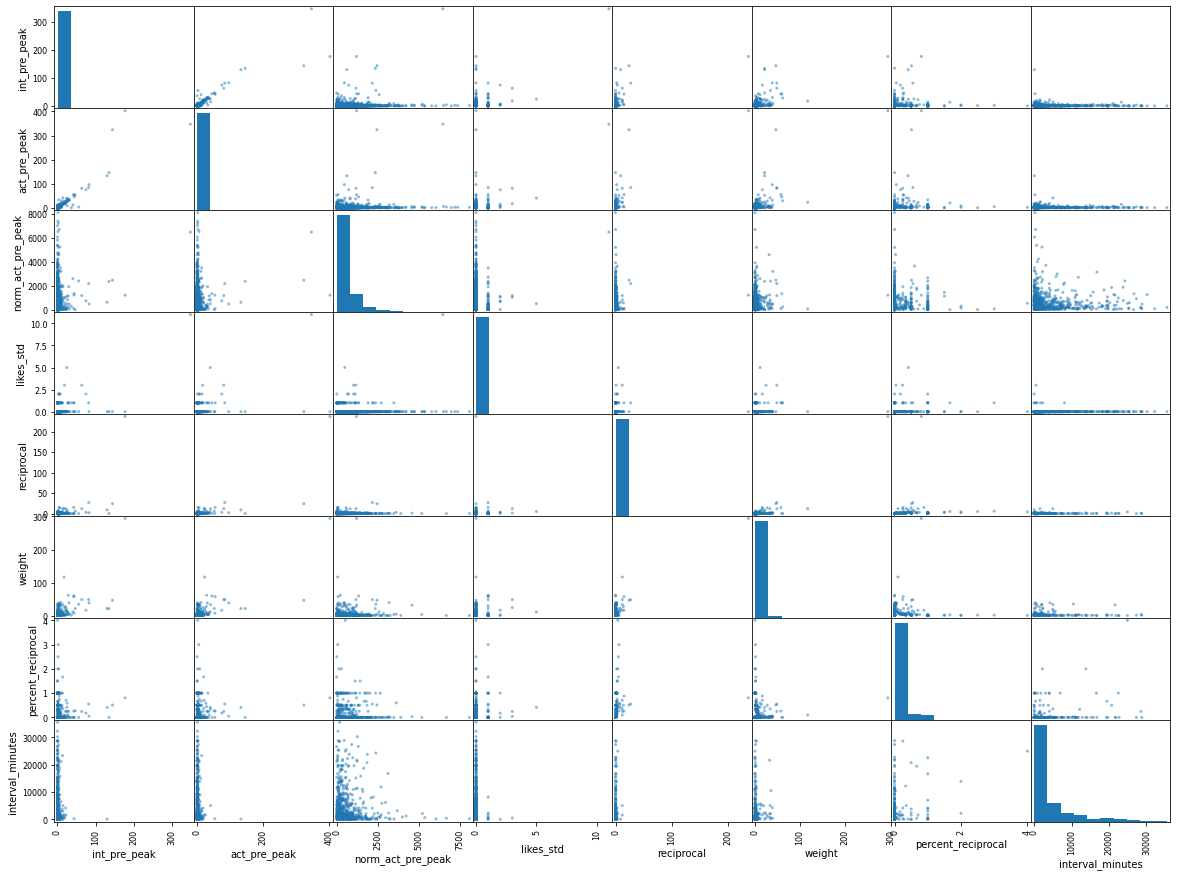

In [39]:
scatter_vis(df, target = 'interval_minutes', group_num=group_num)

In [40]:
# foward selection for cluster change:
best_forward_model = model_selection(
    df.drop(['interval','author_id','act_post_peak','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak'], axis=1),
    'same_cluster_change',
    sm.families.family.Gaussian()
)

# foward selection for cluster change:
best_backward_model = model_selection(
    df.drop(['interval','author_id','act_post_peak','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak'], axis=1),
    'same_cluster_change',
    sm.families.family.Gaussian(),
    forward=False
)

In [41]:
best_forward_model.summary()
write_to_latex(best_forward_model.summary(), group_num, 'same_cluster_change', forward=True)

best_backward_model.summary()
write_to_latex(best_backward_model.summary(), group_num, 'same_cluster_change', forward=False)

In [42]:
# foward selection for act post peak:
best_forward_model_act = model_selection(
    df.drop(['interval','author_id','same_cluster_change','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'act_post_peak'
)

# foward selection for act post peak:
best_backward_model_act = model_selection(
    df.drop(['interval','author_id','same_cluster_change','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'act_post_peak',
    forward=False
)

In [43]:
best_forward_model_act.summary()
write_to_latex(best_backward_model_act.summary(), group_num, 'act_post_peak', forward=True)

best_backward_model_act.summary()
write_to_latex(best_backward_model_act.summary(), group_num, 'act_post_peak', forward=False)

In [44]:
best_forward_model_interval = model_selection(
    df.drop(['interval','author_id','same_cluster_change','act_post_peak','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'interval_minutes',
    forward=True
)

best_backward_model_interval = model_selection(
    df.drop(['interval','author_id','same_cluster_change','act_post_peak','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'interval_minutes',
    forward=False
)

In [45]:
best_forward_model_interval.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       interval_minutes   No. Observations:                  744
Model:                            GLM   Df Residuals:                      740
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6849.7
Date:                Sun, 20 Feb 2022   Deviance:                       809.28
Time:                        15:05:22   Pearson chi2:                     800.
No. Iterations:                     9   Pseudo R-squ. (CS):          0.0004970
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.1806      0.040    103.257      0.000       4.101       4.260
gender[T.True]           -0.0146      0.107     -0.136      0.892      -0.224       0.195
lang_diff[T.True]         4.1806      0.040    103.257      0.000       4.101       4.260
norm_act_pre_peak_avg    -0.0002      0.002     -0.137      0.891      -0.004       0.003
act_pre_peak_avg         -0.2062      0.251     -0.821      0.412      -0.699       0.286
=========================================================================================
"""

In [46]:
best_forward_model_interval.summary()
write_to_latex(best_backward_model_interval.summary(), group_num, 'interval_minutes', forward=True)

best_backward_model_interval.summary()
write_to_latex(best_backward_model_interval.summary(), group_num, 'interval_minutes', forward=False)

## Research Question 2: Drilling Down

In [8]:
df['ht'].value_counts()

metoo               2007
timesup              488
wetoo                 73
niunamenos            40
balancetonporc        37
withyou               29
cuentalo              13
moiaussi               9
memyös                 7
quellavoltache         6
yotambien              5
ricebunny              2
私も                     2
나도                     2
nårdansenstopper       1
stilleforopptak        1
tôicũngvậy             1
woyeshi                1
ятоже                  1
我也是                    1
Name: ht, dtype: int64

In [21]:
df[df['ht']=='yotambien']

,author_id,int_pre_peak,act_pre_peak,act_pre_peak_avg,norm_act_pre_peak,norm_act_pre_peak_avg,act_post_peak,act_post_peak_avg,ht,primary_ht,...,gender,lang,hashtag_lang,lang_diff,interval,interval_minutes,same_cluster_change,weight,reciprocal,percent_reciprocal
2715,227862402,1,0.0,0.000000,1564,22.028169,0.0,0.0,yotambien,metoo,...,False,un,es,True,0 days 13:32:18,812.300000,NaN,NaN,NaN,NaN
2716,302044030,2,2.0,0.041667,1104,23.000000,0.0,0.0,yotambien,metoo,...,True,en,es,True,39 days 02:26:05,56306.083333,NaN,NaN,NaN,NaN
2717,45840741,1,0.0,0.000000,1355,29.456522,0.0,0.0,yotambien,metoo,...,True,es,es,False,NaT,NaN,0.0,1.0,0.0,0.0
2718,900466299129802753,157,89.0,4.944444,4,0.222222,0.0,0.0,yotambien,metoo,...,True,en,es,True,77 days 18:02:57,111962.950000,1.0,22.0,0.0,0.0
2719,906595505135931393,1,0.0,0.000000,2,0.200000,0.0,0.0,yotambien,metoo,...,True,es,es,False,NaT,NaN,NaN,NaN,NaN,NaN


In [20]:
ht_select = 'niunamenos'

data = df.drop(['interval','author_id','interval_minutes','same_cluster_change', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1)

data = data[data['ht']==ht_select]

x = model_selection(
    data,
    'act_post_peak',
    forward=True
    # family = sm.families.family.Gaussian(),
)

data = df.drop(['interval','author_id','same_cluster_change','act_post_peak', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1)

data = data[data['ht']==ht_select]

y = model_selection(
    data,
    'interval_minutes',
    forward=True
)

data = df.drop(['interval','author_id','interval_minutes','act_post_peak', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1)

data = data[data['ht']==ht_select]

z = model_selection(
    data,
    'same_cluster_change',
    family=sm.families.family.Gaussian(),
    forward=True
)

/home/hubert/.local/lib/python3.9/site-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid
/home/hubert/.local/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/hubert/.local/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1342: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/hubert/.local/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:1346: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/home/hubert/.local/lib/python3.9/site-packages/statsmodels/genmod/families/family.py:132: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/hubert/.local/lib/python3.9/site-packages/statsmodels/gen

PerfectSeparationError: Perfect separation detected, results not available

In [17]:
x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          act_post_peak   No. Observations:                   73
Model:                            GLM   Df Residuals:                       63
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -72.766
Date:                Sun, 20 Feb 2022   Deviance:                       48.649
Time:                        12:40:41   Pearson chi2:                     52.6
No. Iterations:                    13   Pseudo R-squ. (CS):            0.06571
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.1560      0.263     -0.592      0.554      -0.672       0.360
age[T.30-39]              0.1855      0.581      0.319      0.750      -0.954       1.325
age[T.<=18]              -0.6004      0.827     -0.726      0.468      -2.222       1.021
age[T.>=40]              -0.1241      0.680     -0.182      0.855      -1.456       1.208
org[T.True]              -0.5932      0.705     -0.841      0.400      -1.976       0.789
gender[T.True]           -0.5180      0.482     -1.074      0.283      -1.463       0.427
lang_diff[T.True]        -0.1560      0.263     -0.592      0.554      -0.672       0.360
act_pre_peak              0.0018      0.006      0.316      0.752      -0.010       0.013
int_pre_peak             -0.0088      0.012     -0.709      0.478      -0.033       0.016
norm_act_pre_peak_avg     0.0027      0.012      0.217      0.828      -0.022       0.027
likes_std                 0.0983      0.109      0.901      0.368      -0.116       0.312
=========================================================================================
"""

In [18]:
y.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:       interval_minutes   No. Observations:                   36
Model:                            GLM   Df Residuals:                       35
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -370.07
Date:                Sun, 20 Feb 2022   Deviance:                       138.45
Time:                        12:40:44   Pearson chi2:                     16.4
No. Iterations:                   100   Pseudo R-squ. (CS):             -6.671
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.8666      0.118     49.769      0.000       5.636       6.098
lang_diff[T.True]     5.8666      0.118     49.769      0.000       5.636       6.098
=====================================================================================
"""

In [19]:
z.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     same_cluster_change   No. Observations:                   41
Model:                             GLM   Df Residuals:                       30
Model Family:                 Gaussian   Df Model:                           10
Link Function:                identity   Scale:                         0.21015
Method:                           IRLS   Log-Likelihood:                -19.794
Date:                 Sun, 20 Feb 2022   Deviance:                       6.3045
Time:                         12:40:47   Pearson chi2:                     6.30
No. Iterations:                      3   Pseudo R-squ. (CS):             0.1565
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0985      0.144      0.684      0.494      -0.184       0.381
age[T.30-39]           0.1071      0.204      0.526      0.599      -0.292       0.506
age[T.<=18]            0.1845      0.257      0.719      0.472      -0.319       0.687
age[T.>=40]           -0.2078      0.195     -1.065      0.287      -0.590       0.175
gender[T.True]         0.0862      0.158      0.544      0.586      -0.224       0.397
int_pre_peak           0.0021      0.003      0.612      0.540      -0.005       0.009
percent_reciprocal     0.0117      0.150      0.078      0.938      -0.282       0.305
likes_std              0.0101      0.059      0.172      0.863      -0.105       0.126
reciprocal            -0.0042      0.014     -0.288      0.773      -0.032       0.024
weight                -0.0045      0.013     -0.345      0.730      -0.030       0.021
act_pre_peak          -0.0014      0.002     -0.904      0.366      -0.005       0.002
======================================================================================
"""

# Group 2: 

In [22]:
group_num = 3
hashtag_split = True
ngram_range = '34'
min_user = 100

overwrite = True
read_in = True

df = read_in_data(group_num)

In [23]:
df['ht'].value_counts()

metoo         1242
niunamenos     627
kutoo          396
moiaussi        11
watashimo        1
ятоже            1
Name: ht, dtype: int64

In [24]:
df.describe()


,int_pre_peak,act_pre_peak,norm_act_pre_peak,act_pre_peak_avg,norm_act_pre_peak_avg,act_post_peak,act_post_peak_avg,likes_std,interval,interval_minutes,same_cluster_change,weight,reciprocal,percent_reciprocal
count,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,529,529.000000,554.000000,562.000000,562.000000,562.000000
mean,2.514925,1.591747,394.177788,0.080945,22.372460,0.561896,0.080042,0.031607,3 days 00:56:33.103969754,4376.551733,-0.135148,4.322064,0.873665,0.114269
std,10.167611,13.739248,608.031509,0.695000,31.324753,1.936721,0.373144,0.309223,4 days 10:06:17.678049904,6366.294634,0.417396,14.104064,10.169511,0.333532
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0 days 00:01:22,1.366667,-1.000000,1.000000,0.000000,0.000000
25%,1.000000,0.000000,47.000000,0.000000,3.821970,0.000000,0.000000,0.000000,0 days 09:51:51,591.850000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,181.000000,0.000000,11.857143,0.000000,0.000000,0.000000,1 days 00:54:10,1494.166667,0.000000,2.000000,0.000000,0.000000
75%,2.000000,1.000000,498.000000,0.029412,29.254545,1.000000,0.090909,0.000000,3 days 20:56:51,5576.850000,0.000000,3.000000,0.000000,0.000000
max,347.000000,396.000000,7216.000000,22.466667,354.875000,66.000000,13.000000,11.000000,24 days 14:45:33,35445.550000,1.000000,292.000000,237.000000,4.000000


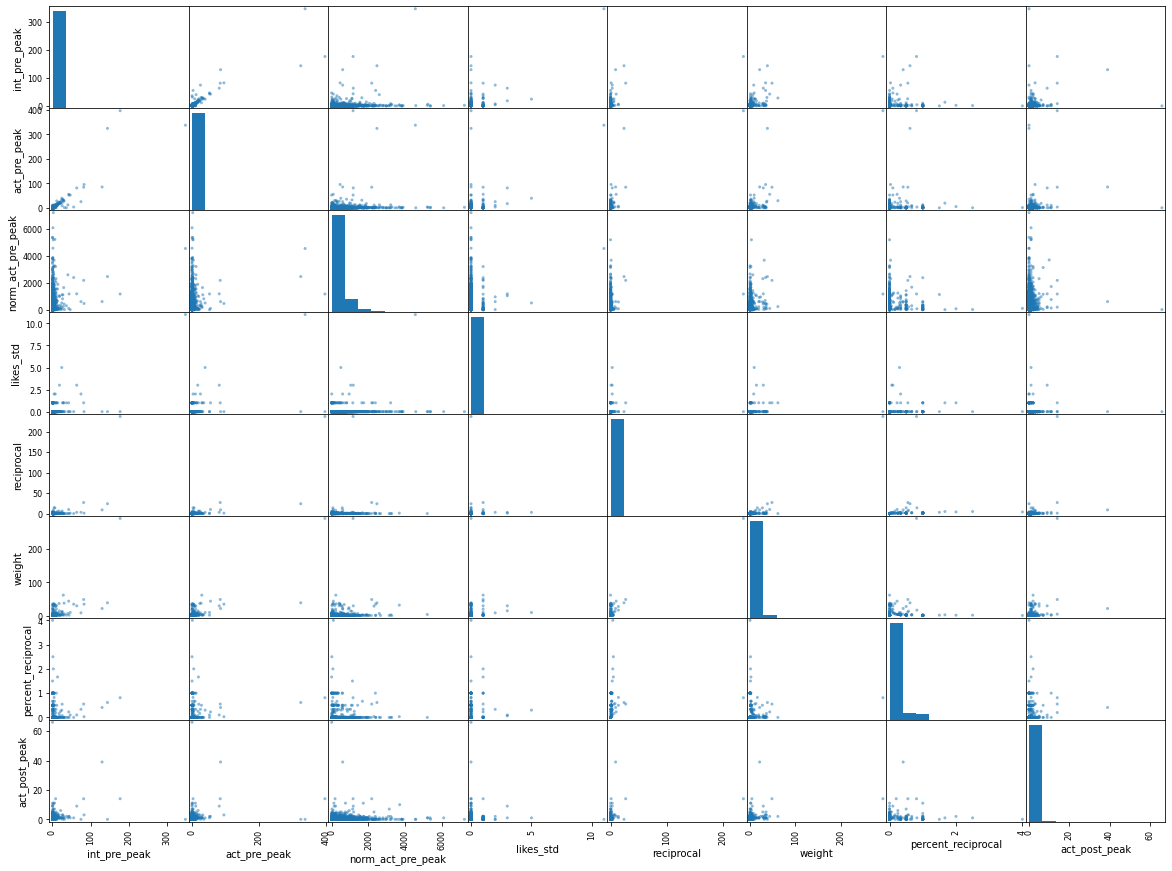

In [25]:
scatter_vis(df, target = 'act_post_peak', group_num=group_num)

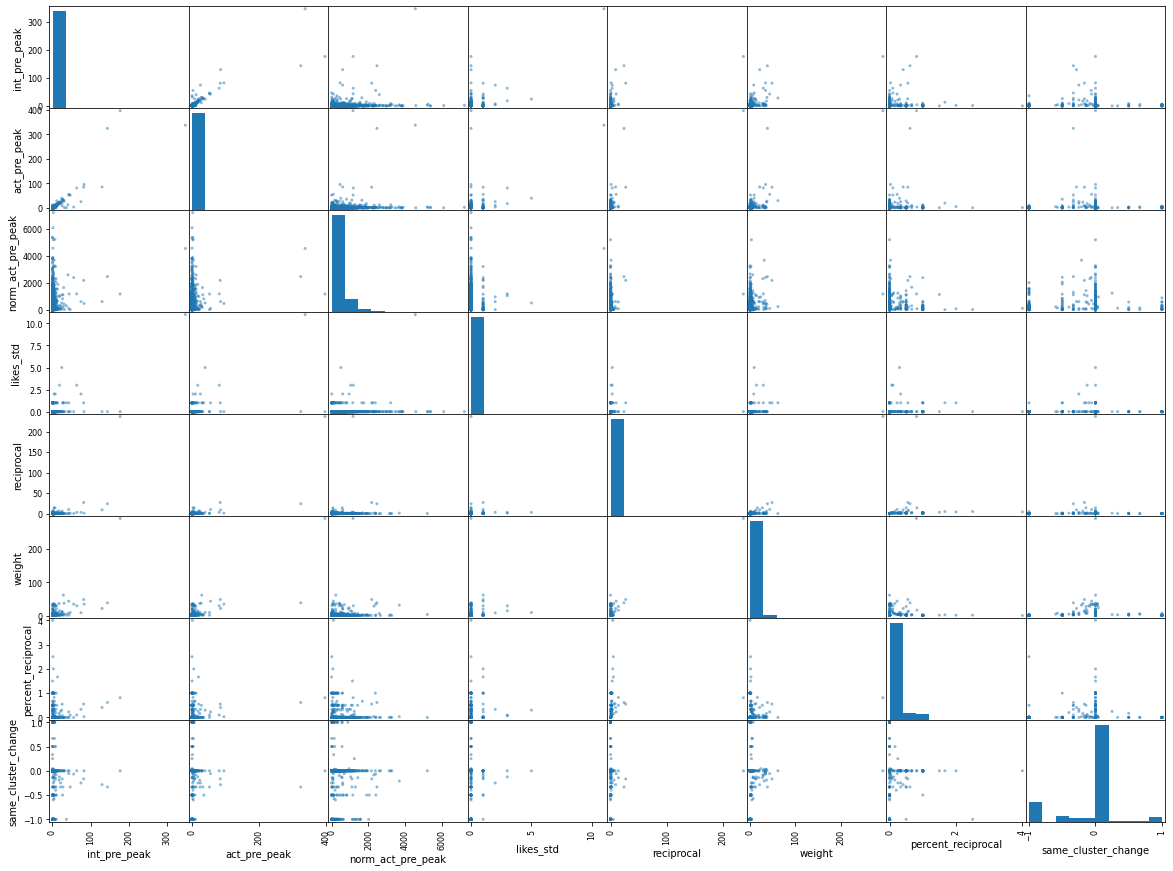

In [26]:
scatter_vis(df, target = 'same_cluster_change', group_num=group_num)

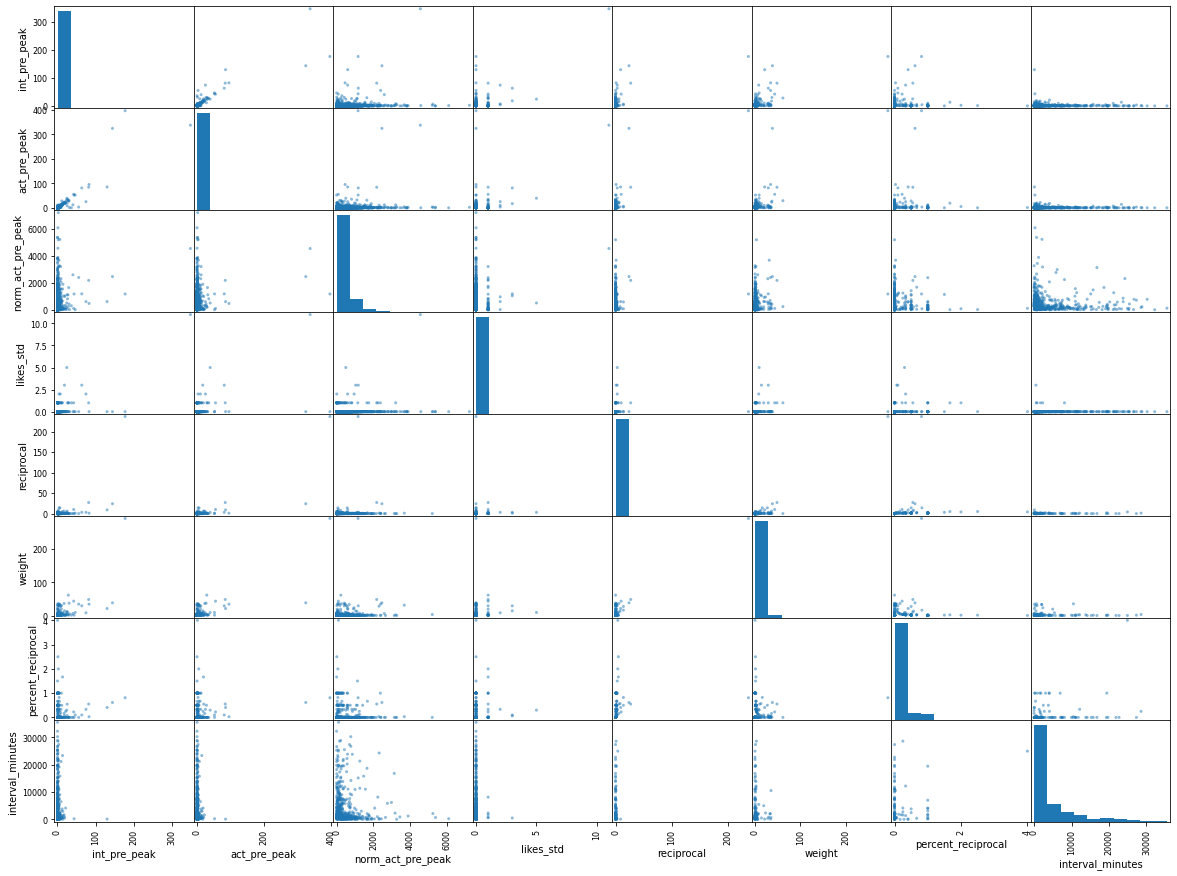

In [27]:
scatter_vis(df, target = 'interval_minutes', group_num=group_num)

In [ ]:
# foward selection for cluster change:
best_forward_model = model_selection(
    df.drop(['interval','author_id','act_post_peak','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak'], axis=1),
    'same_cluster_change',
    sm.families.family.Gaussian()
)

In [ ]:
best_forward_model.summary()

In [ ]:
# foward selection for cluster change:
best_backward_model = model_selection(
    df.drop(['interval','author_id','act_post_peak','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak'], axis=1),
    'same_cluster_change',
    sm.families.family.Gaussian(),
    forward=False
)

In [ ]:
best_backward_model.summary()

In [ ]:
# foward selection for act post peak:
best_forward_model_act = model_selection(
    df.drop(['interval','author_id','same_cluster_change','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'act_post_peak'
)

In [ ]:
best_forward_model_act.summary()

In [ ]:
# foward selection for act post peak:
best_backward_model_act = model_selection(
    df.drop(['interval','author_id','same_cluster_change','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'act_post_peak',
    forward=False
)

In [ ]:
best_backward_model_act.summary()

In [ ]:
best_forward_model_interval = model_selection(
    df.drop(['interval','author_id','same_cluster_change','act_post_peak','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'interval_minutes',
    forward=True
)

In [ ]:
best_forward_model_interval.summary()

In [ ]:
best_backward_model_interval = model_selection(
    df.drop(['interval','author_id','same_cluster_change','act_post_peak','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'interval_minutes',
    forward=False
)

In [ ]:
best_backward_model_interval.summary()

## Drilling Down: Analysis per hashtag

In [ ]:
df['ht'].value_counts()

In [ ]:
data = df.drop(['interval','author_id','interval_minutes','same_cluster_change', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1)

data = data[~data['lang_diff']]

x = model_selection(
    data,
    'act_post_peak',
    forward=True
    # family = sm.families.family.Gaussian(),
)

In [ ]:
x.summary()

In [ ]:
df[df['ht']=='ятоже']

# Group 3: 2020-02-03 to 2020-03-16

In [ ]:
group_num = 3
hashtag_split = True
ngram_range = '34'
min_user = 100

overwrite = True
read_in = True

df = read_in_data(group_num)

In [ ]:
df

In [ ]:
df.describe()

In [ ]:
scatter_vis(df)

In [ ]:
# foward selection for cluster change:
best_forward_model = model_selection(
    df.drop(['interval','author_id','act_post_peak','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak'], axis=1),
    'same_cluster_change',
    sm.families.family.Gaussian()
)

In [ ]:
best_forward_model.summary()

In [ ]:
# foward selection for cluster change:
best_backward_model = model_selection(
    df.drop(['interval','author_id','act_post_peak','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak'], axis=1),
    'same_cluster_change',
    sm.families.family.Gaussian(),
    forward=False
)

In [ ]:
best_backward_model.summary()

In [ ]:
# foward selection for act post peak:
best_forward_model_act = model_selection(
    df.drop(['interval','author_id','same_cluster_change','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'act_post_peak'
)

In [ ]:
best_forward_model_act.summary()

In [ ]:
# foward selection for act post peak:
best_backward_model_act = model_selection(
    df.drop(['interval','author_id','same_cluster_change','interval_minutes','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'act_post_peak',
    forward=False
)

In [ ]:
best_backward_model_act.summary()

In [ ]:
best_forward_model_interval = model_selection(
    df.drop(['interval','author_id','same_cluster_change','act_post_peak','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'interval_minutes',
    forward=True
)

In [ ]:
best_forward_model_interval.summary()

In [ ]:
best_backward_model_interval = model_selection(
    df.drop(['interval','author_id','same_cluster_change','act_post_peak','ht', 'lang', 'hashtag_lang', 'norm_act_pre_peak', 'act_post_peak_avg'], axis=1),
    'interval_minutes',
    forward=False
)

In [ ]:
best_backward_model_interval.summary()